# Combining networks and check integrity

In [1]:

import sys # for automation and parallelization: set manual to false when run by a launcher
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
sys.path.insert(0, r'../../../quetzal')

import os
from quetzal.model import stepmodel
import geopandas as gpd

if manual:
    %matplotlib inline

SQLalchemy is not installed. No support for SQL output.


In [2]:
is_lambda = (os.environ.get("AWS_LAMBDA_FUNCTION_NAME") is not None)

if is_lambda:
    model_folder = 's3://quetzal-paris/dev'
    training_folder = os.environ.get("LAMBDA_TASK_ROOT")
else:
    model_folder = '../../model'
    training_folder = '../..'
    
input_folder = training_folder + '/inputs/'


# Import Networks

## Transport Network

In [3]:
sm = stepmodel.StepModel(epsg = 4326, coordinates_unit = 'degree')
sm.links = gpd.read_file(input_folder + 'gtfs/links.geojson', driver='GeoJSON').set_index('index')
sm.nodes = gpd.read_file(input_folder + 'gtfs/nodes.geojson', driver='GeoJSON').set_index('index')

# Add zones
sm.zones = gpd.read_file(input_folder + 'zones/zones.geojson', driver='GeoJSON').set_index('index')

# Road Network

In [4]:
sm.road_links = gpd.read_file(input_folder + 'road/road_links.geojson', driver='GeoJSON').set_index('index')
sm.road_nodes = gpd.read_file(input_folder + 'road/road_nodes.geojson', driver='GeoJSON').set_index('index')

# Road Integrity

In [5]:
sm.integrity_fix_collision()

can not add prefixes on table:  footpaths


In [6]:
sm.integrity_fix_road_network(cutoff=10, recursive_depth=5)

direct: 5698it [00:00, 17778.56it/s]
reversed: 5698it [00:00, 18278.57it/s]
5690it [00:00, 17645.66it/s]


In [7]:
sm.integrity_fix_nodeset_consistency()

## Road Test

In [8]:
sm.integrity_test_dead_ends()

5690it [00:00, 53924.64it/s]


In [9]:
sm.integrity_test_isolated_roads()

# Transport Integrity

In [10]:
sm.integrity_fix_collision()

In [11]:
sm.integrity_fix_circular_lines()

dropped circular lines: ['100100059:59_2', '100100290:290_1', '100100105:105_1', '100100323:323_1', '100100129:129_1', '100100191:191_2', '100100249:249_1']


In [12]:
sm.integrity_fix_sequences()

In [13]:
sm.integrity_fix_nodeset_consistency()

## Transport Test

In [14]:
sm.integrity_test_all(errors='raise')

5690it [00:00, 57567.37it/s]

passed: integrity_test_circular_lines
passed: integrity_test_collision
passed: integrity_test_dead_ends
passed: integrity_test_isolated_roads
passed: integrity_test_nodeset_consistency



5690it [00:00, 17514.83it/s]


passed: integrity_test_road_network
passed: integrity_test_road_nodeset_consistency
passed: integrity_test_sequences


# Export

In [18]:
# Convert model to meters
sm = sm.change_epsg(epsg=3857, coordinates_unit='meter')

sm.to_zippedpickles(model_folder + '/{scen}/networks'.format(scen=scenario))

orphan_nodes: 100%|██████████| 17/17 [00:01<00:00, 11.62it/s]   


Reprojecting model from epsg 4326 to epsg 3857: 100%|██████████| 17/17 [00:00<00:00, 18.76it/s]


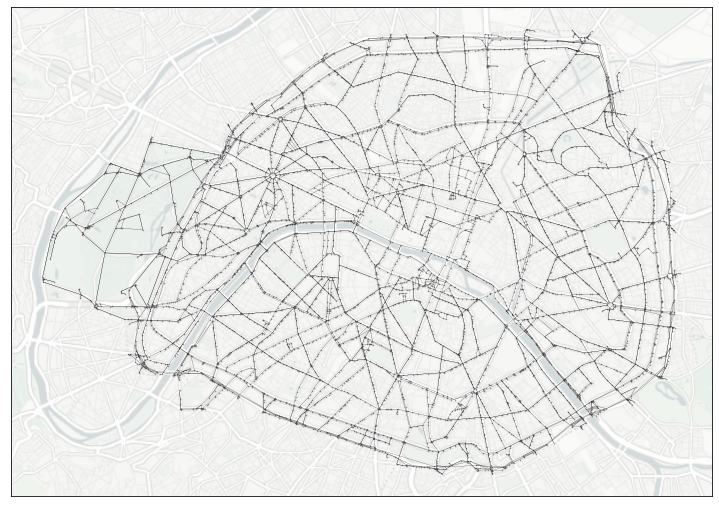

In [16]:
if manual:
    sm_3857 = sm.change_epsg(epsg=3857, coordinates_unit='meter').copy()
    sm_3857.plot(
        'road_nodes', color='grey', markersize=0.2,
        ax=sm.plot(
            'road_links', figsize=[16, 9], 
            basemap_url= 'http://a.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}.png', linewidth=0.2, color='black'
        ),    
    )

# END